In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, normalize
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import time
import pickle
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import sklearn
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc

 # Loading the data

In [2]:
def creating_dataset(filename):
    df = pd.read_csv('dataset/'+str(filename), index_col=[0])
    X = df.drop('DEP_DEL15', axis=1).drop("LONGITUDE",axis=1).drop("LATITUDE",axis=1)
    y = df['DEP_DEL15']
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,shuffle=True)
    x_train,x_test = scaleNorm(x_train,x_test)
    return x_train,x_test,y_train,y_test

def redoSplit(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42,shuffle=True)
    return x_train,x_test,y_train,y_test

def balancing_dataset(x_train,y_train,drop_per):
    idx = np.where(y_train == 0)[0]
    x_train = (x_train.drop(x_train.index[idx[:int(len(idx)*drop_per)]]))
    y_train = (y_train.drop(y_train.index[idx[:int(len(idx)*drop_per)]]))
    return x_train,y_train

def standardize(x):
    x = x.to_numpy()
    x = (x- np.min(x,axis=0))/np.max(x,axis=0)
    return x

def scaleNorm(X_train,X_test):
    X_train = standardize(X_train)
    X_test = standardize(X_test)
    return pd.DataFrame(X_train),pd.DataFrame(X_test)

In [3]:
X,x_real_test,Y,y_real_test = creating_dataset('datasetcleaned_full.csv')
cols = pd.read_csv('dataset/datasetcleaned_full.csv', index_col=[0]).drop('DEP_DEL15', axis=1).drop("LONGITUDE",axis=1).drop("LATITUDE",axis=1).columns

 # Models

In [4]:
#baseline
y_pred = np.random.randint(0,2,Y.shape)
cm = confusion_matrix(Y, y_pred)
print(cm /np.sum(cm,axis=0))

[[0.8053428  0.80484691]
 [0.1946572  0.19515309]]


In [5]:
#shuffling data
x_train,x_val,y_train,y_val = redoSplit(X,Y)
x,y = balancing_dataset(x_train,y_train,0.8)
x_train_drop,x_test_drop,y_train_drop,y_test_drop = redoSplit(x,y)
#with weights
weights = y_train.to_numpy()*4 + 1
xb_modelW = xgb.XGBClassifier(weight=weights)
xb_modelW.fit(x_train, y_train)
y_hat = xb_modelW.predict(x_val)
cm = confusion_matrix(y_val, y_hat)
print("weighted",cm /np.sum(cm,axis=0))

xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train_drop,y_train_drop)
y_pred_test = xgb_model.predict(x_test_drop)
cm_test = confusion_matrix(y_pred_test,y_test_drop.to_numpy())
print("simple drop",cm_test /np.sum(cm_test,axis=0))

/Users/Diego/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:18:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:576: 
Parameters: { "weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:18:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weighted [[0.820287   0.32659458]
 [0.179713   0.67340542]]
[09:23:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old

In [6]:
#shuffling data
x_train,x_val,y_train,y_val = redoSplit(X,Y)
x,y = balancing_dataset(x_train,y_train,0.8)
x_train_drop,x_test_drop,y_train_drop,y_test_drop = redoSplit(x,y)
#with weights
clf_RFW = RandomForestClassifier(max_depth=2, random_state=0,class_weight = {0:1,1:5})
clf_RFW.fit(x_train, y_train)
y_hat = clf_RFW.predict(x_val)
cm = confusion_matrix(y_val, y_hat)
print("weigthed",cm /np.sum(cm,axis=0))

#simple drop
clf_RF = RandomForestClassifier(max_depth=2, random_state=0)
clf_RF.fit(x_train_drop, y_train_drop)
y_hat = clf_RF.predict(x_test_drop)
cm = confusion_matrix(y_test_drop, y_hat)
print("simple drop",cm /np.sum(cm,axis=0))

weigthed [[0.89709776 0.77216429]
 [0.10290224 0.22783571]]
simple drop [[0.63904371 0.40381612]
 [0.36095629 0.59618388]]


In [11]:
#shuffling data
x_train,x_val,y_train,y_val = redoSplit(X,Y)
x,y = balancing_dataset(x_train,y_train,0.8)
x_train_drop,x_test_drop,y_train_drop,y_test_drop = redoSplit(x,y)

#simple drop
clf_Cat = CatBoostClassifier()
# clf_Cat.fit(x_train_drop, y_train_drop, verbose=False)
y_hat = clf_Cat.predict(x_test_drop)
cm = confusion_matrix(y_test_drop, y_hat)
print("simple drop",cm /np.sum(cm,axis=0))

#with weights
clf = CatBoostClassifier(class_weights = [1,5])
# clf.fit(x_train, y_train)
train_acc,t_acc = clf.score(x_train, y_train), clf.score(x_val, y_val)
y_hat = clf.predict(x_val)
cm = confusion_matrix(y_val, y_hat)
print("weighted",cm /np.sum(cm,axis=0))

#with inverted weights?
clf_catInvW = CatBoostClassifier(class_weights = [5,1],early_stopping_rounds=5)
# clf_catInvW.fit(x_train, y_train)
train_acc,t_acc = clf_catInvW.score(x_train, y_train), clf_catInvW.score(x_val, y_val)
y_hat = clf_catInvW.predict(x_val)
cm = confusion_matrix(y_val, y_hat)
print("inverted weights",cm /np.sum(cm,axis=0))

#with inverted weights?
clf_catInvAuto = CatBoostClassifier(auto_class_weights = 'Balanced',early_stopping_rounds=5)
# clf_catInvAuto.fit(x_train, y_train)
y_hat = clf_catInvAuto.predict(x_val)
cm = confusion_matrix(y_val, y_hat)
print("auto weigthed",cm /np.sum(cm,axis=0))

KeyboardInterrupt: 

In [ ]:
cols[np.argsort(clf_catInvW.feature_importances_)]

### Deep Learning

#### AutoML

In [12]:
LOG_DIR = f"{int(time.time())}"

# tensorboard = TensorBoard(log_dir=LOG_DIR)

def build_model(hp):  # random search passes this hyperparameter() object 
    model = keras.models.Sequential()

    model.add(Dense(hp.Int('input_units',min_value=50, max_value=200, step=50), 
                    input_shape=X.shape[1:],
                    activation='relu'))

    model.add( Dropout(hp.Float('dropout_rate',
                                    min_value=0.0,
                                    max_value=0.5,
                                    step=0.1) ) )
    
    for i in range(hp.Int('n_layers', 1, 2)):  # adding variation of layers.
        model.add(Dense(hp.Int(f'layer_{i}_units',
                                min_value=10,
                                max_value=150,
                                step=30), 
                                activation='relu'))
    
        model.add( Dropout(hp.Float(f'dropout_{i}_rate',
                                    min_value=0.0,
                                    max_value=0.5,
                                    step=0.1) ) )
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
              
    return model
                  

tuner = RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=10,  # how many variations on model?
    executions_per_trial=1) # how many trials per variation? (same model could perform differently)


tuner.search_space_summary()

tuner.search(x=X,
             y=Y,
             epochs=5,
             batch_size=64)

tuner.results_summary()

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
Search space summary
Default search space size: 7
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': None}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}
layer_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 150, 'step': 30, 'sampling': None}
dropout_0_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 150, 'step': 30, 'sampling': None}
dropout_1_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0,

#### DL model

In [13]:
def build_model():  # random search passes this hyperparameter() object 
    model = keras.models.Sequential()

    model.add(Dense(200, input_shape=X.shape[1:], activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add( Dropout( 0.1 ) )
    model.add(Dense(70, activation='relu'))
    model.add( Dropout( 0.4 ) )
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
              
    return model
                  

model = build_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1)
reducer = tf.keras.callbacks.ReduceLROnPlateau( monitor='loss', factor=0.5, patience=3, verbose=1, mode='min')


model.fit(X,Y, callbacks=[early_stopping, reducer], batch_size=256,verbose=1,epochs=1000 )

Epoch 1/1000
17114/17114 [==============================] - 26s 1ms/step - loss: 0.4632 - accuracy: 0.8071
Epoch 2/1000
17114/17114 [==============================] - 26s 2ms/step - loss: 0.4558 - accuracy: 0.8093
Epoch 3/1000
17114/17114 [==============================] - 26s 2ms/step - loss: 0.4538 - accuracy: 0.8101
Epoch 4/1000
17114/17114 [==============================] - 26s 2ms/step - loss: 0.4525 - accuracy: 0.8106
Epoch 5/1000
17114/17114 [==============================] - 26s 1ms/step - loss: 0.4514 - accuracy: 0.8111
Epoch 6/1000
17114/17114 [==============================] - 26s 2ms/step - loss: 0.4507 - accuracy: 0.8114
Epoch 7/1000
17114/17114 [==============================] - 25s 1ms/step - loss: 0.4499 - accuracy: 0.8118
Epoch 8/1000
17114/17114 [==============================] - 27s 2ms/step - loss: 0.4494 - accuracy: 0.8119
Epoch 9/1000
17114/17114 [==============================] - 26s 2ms/step - loss: 0.4489 - accuracy: 0.8121
Epoch 10/1000
17114/17114 [==========

17114/17114 [==============================] - 26s 2ms/step - loss: 0.4395 - accuracy: 0.8164

Epoch 00073: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 74/1000
17114/17114 [==============================] - 25s 1ms/step - loss: 0.4394 - accuracy: 0.8165
Epoch 75/1000
17114/17114 [==============================] - 26s 2ms/step - loss: 0.4394 - accuracy: 0.8165
Epoch 76/1000
17114/17114 [==============================] - 26s 2ms/step - loss: 0.4394 - accuracy: 0.8164
Epoch 77/1000
17114/17114 [==============================] - 26s 2ms/step - loss: 0.4393 - accuracy: 0.8164

Epoch 00077: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 78/1000
17114/17114 [==============================] - 26s 2ms/step - loss: 0.4393 - accuracy: 0.8164
Epoch 79/1000
17114/17114 [==============================] - 26s 2ms/step - loss: 0.4393 - accuracy: 0.8165
Epoch 80/1000
17114/17114 [==============================] - 26s 2ms/step - loss: 0.4393 - accu

In [14]:
y_hat = model.predict_classes(x_real_test)
print("Test accuracy", sklearn.metrics.accuracy_score(y_real_test, y_hat))

/Users/Diego/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test accuracy 0.816284158982064


### Confusion Matrix

In [21]:
y_hat = clf.predict(x_real_test)
cm = confusion_matrix(y_real_test, y_hat)
cm /np.sum(cm,axis=0)

array([[0.90278662, 0.69488369],
       [0.09721338, 0.30511631]])

### Precision Recall Curve


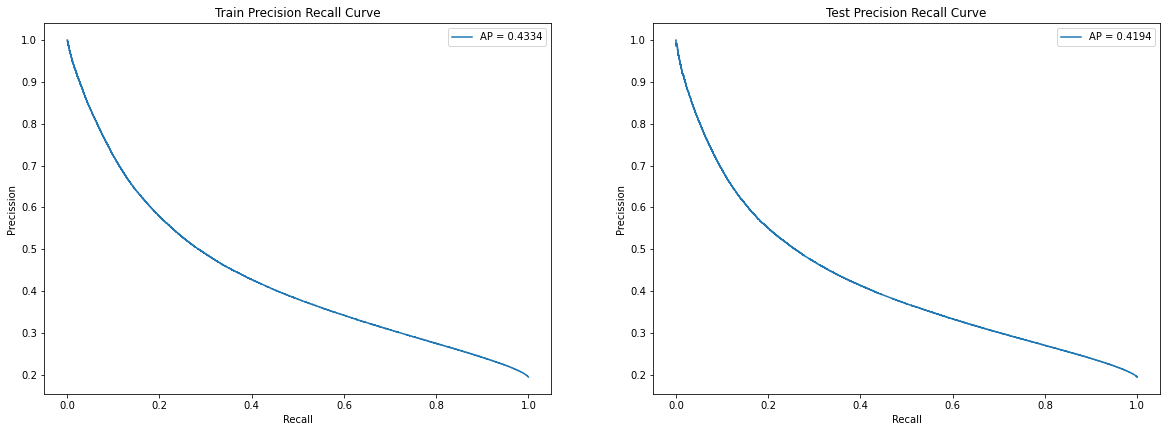

In [16]:
y_train_pred = model.predict(X)
train_precision, train_recall, _ = precision_recall_curve(Y, y_train_pred)
train_ap = average_precision_score(Y, y_train_pred)
y_test_pred = model.predict(x_real_test)
test_precision, test_recall, _ = precision_recall_curve(y_real_test, y_test_pred)
test_ap = average_precision_score(y_real_test, y_test_pred)


plt.figure(figsize=(20, 15))

axs = plt.subplot(2,2,1)
axs.set_title('Train Precision Recall Curve')
axs.set_xlabel('Recall')
axs.set_ylabel('Precission')
axs.plot(train_recall, train_precision, label = 'AP = {:.4f}'.format(train_ap))
axs.legend()

axs = plt.subplot(2,2,2)
axs.set_title('Test Precision Recall Curve')
axs.set_xlabel('Recall')
axs.set_ylabel('Precission')
axs.plot(test_recall, test_precision, label = 'AP = {:.4f}'.format(test_ap))
axs.legend()

### ROC curve

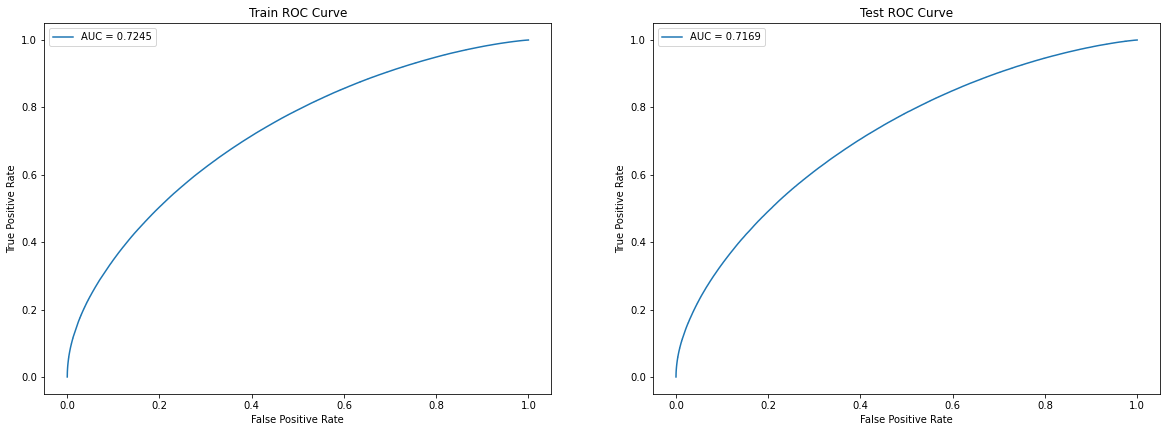

In [17]:
train_fpr, train_tpr, _ = roc_curve(Y, y_train_pred)
train_auc = auc(train_fpr, train_tpr)

test_fpr, test_tpr, _ = roc_curve(y_real_test, y_test_pred)
test_auc = auc(test_fpr, test_tpr)

plt.figure(figsize=(20, 15))

axs = plt.subplot(2,2,1)
axs.set_title('Train ROC Curve')
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')
axs.plot(train_fpr, train_tpr, label = 'AUC = {:.4f}'.format(train_auc))
axs.legend()

axs = plt.subplot(2,2,2)
axs.set_title('Test ROC Curve')
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')
axs.plot(test_fpr, test_tpr, label = 'AUC = {:.4f}'.format(test_auc))
axs.legend()
plt.show()